In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import VeraRubin as vr
import numpy as np

from lsst.afw.image import ExposureF, MaskedImageF, ImageF
from lsst.source.injection import VisitInjectConfig, VisitInjectTask, generate_injection_catalog
from lsst.geom import SpherePoint, degrees

from astropy.io import fits

In [3]:
def fits_to_exposure(data, hdr, variance_init=1.0):
    """
    Convert a NumPy array + FITS header into an LSST ExposureF,
    initializing variance and mask planes.
    
    Parameters
    ----------
    data : np.ndarray
        Image data (2D array).
    hdr : astropy.io.fits.Header
        FITS header with WCS keywords.
    variance_init : float, optional
        Default variance value to assign to all pixels.
    
    Returns
    -------
    exposure : lsst.afw.image.ExposureF
        LSST Exposure with WCS, mask, and variance.
    """
    import lsst.geom as geom
    from lsst.afw.geom import makeSkyWcs
    from lsst.afw.image import ImageF, Mask, MaskedImageF, ExposureF
    
    # Create image plane
    image = ImageF(data.astype(np.float32, order="C"), deep=False)

    # Initialize mask (all zeros = good pixels)
    mask = Mask(image.getDimensions())
    mask.set(0)

    # Initialize variance plane (constant value, 1.0)
    variance = ImageF(image.getDimensions())
    variance.set(variance_init)

    # Build masked image (image, mask, variance)
    masked = MaskedImageF(image, mask, variance)

    # Wrap into an ExposureF
    exposure = ExposureF(masked)

    # Build LSST SkyWcs from FITS header keywords
    crpix = geom.Point2D(hdr["CRPIX1"], hdr["CRPIX2"])
    crval = geom.SpherePoint(hdr["CRVAL1"] * geom.degrees,
                             hdr["CRVAL2"] * geom.degrees)
    cd_matrix = np.array([[hdr["CD1_1"], hdr["CD1_2"]],
                          [hdr["CD2_1"], hdr["CD2_2"]]])

    skyWcs = makeSkyWcs(crpix, crval, cd_matrix)
    exposure.setWcs(skyWcs)

    return exposure

def exposure_to_fits_datahdr(exposure):
    """
    Convert an LSST Exposure to FITS-like (data, header).

    Parameters
    ----------
    exposure : `lsst.afw.image.Exposure`
        Input exposure.

    Returns
    -------
    data : 2D numpy.ndarray
        Image array from the exposure.
    hdr : astropy.io.fits.Header
        FITS header including WCS metadata.
    """
    import numpy as np
    from astropy.io import fits

    # Extract image array
    mi = exposure.getMaskedImage()
    data = mi.getImage().getArray()

    # Build WCS header
    wcs = exposure.getWcs()
    hdr = fits.Header()
    hdr.update(wcs.getFitsMetadata())

    return data, hdr

def cutout_exposure(ref_exposure, center_coord, radius_pixels, info=True):
    """
    Cut out an LSST exposure centered on a celestial position with a given radius.
    If the cutout exceeds the image boundaries, missing regions are filled with zeros.
    Updates the WCS of the cutout to remain consistent.

    Parameters
    ----------
    ref_exposure : `lsst.afw.image.Exposure`
        Input exposure.
    center_coord : `lsst.afw.coord.Coord`
        Cutout center in celestial coordinates.
    radius_pixels : float
        Radius of the cutout in pixels.

    Returns
    -------
    cutout_exp : `lsst.afw.image.Exposure`
        Cutout exposure with updated WCS.
    """
    import lsst.geom as geom
    import lsst.afw.image as afwImage
    import numpy as np

    wcs = ref_exposure.getWcs()
    bbox = ref_exposure.getBBox()

    # Convert celestial center to pixel coordinates
    center_point = wcs.skyToPixel(center_coord)

    # Desired cutout BBox
    size = int(2 * radius_pixels)
    min_x = int(center_point.getX() - radius_pixels)
    min_y = int(center_point.getY() - radius_pixels)
    desired_bbox = geom.Box2I(geom.Point2I(min_x, min_y), geom.Extent2I(size, size))

    # Checking if box is subset of desired_bbox
    # when this happened intersect_bbox is clipped to box
    intersect_bbox = desired_bbox.clippedTo(bbox)
    is_subset = (intersect_bbox != bbox)

    if is_subset:
        # Case when intersect_bbox is subset of bbox
        x0, y0 = 0, 0
    else:
        # Case when bbox is subset of intersect_bbox
        x0 = intersect_bbox.getMinX() - desired_bbox.getMinX()
        y0 = intersect_bbox.getMinY() - desired_bbox.getMinY()

    # Create empty arrays for image, mask, and variance
    dtype = ref_exposure.getMaskedImage().getImage().getArray().dtype
    empty_image = np.zeros((size, size), dtype=dtype)
    empty_mask = np.zeros((size, size), dtype=np.uint16)
    empty_variance = np.zeros((size, size), dtype=dtype)

    # Copy image, mask, and variance from the original
    mi = ref_exposure.getMaskedImage()
    empty_image[y0:y0 + intersect_bbox.getHeight() - 1, x0:x0 + intersect_bbox.getWidth() - 1] = \
            mi.getImage().getArray()[intersect_bbox.getMinY():intersect_bbox.getMaxY(),
                                 intersect_bbox.getMinX():intersect_bbox.getMaxX()]
    empty_mask[y0:y0 + intersect_bbox.getHeight() - 1, x0:x0 + intersect_bbox.getWidth() - 1] = \
            mi.getMask().getArray()[intersect_bbox.getMinY():intersect_bbox.getMaxY(),
                                intersect_bbox.getMinX():intersect_bbox.getMaxX()]
    empty_variance[y0:y0 + intersect_bbox.getHeight() - 1, x0:x0 + intersect_bbox.getWidth() - 1] = \
            mi.getVariance().getArray()[intersect_bbox.getMinY():intersect_bbox.getMaxY(),
                                    intersect_bbox.getMinX():intersect_bbox.getMaxX()]
        
    # Create MaskedImage and Exposure
    mi_cutout = afwImage.MaskedImageF(empty_image.shape[1], empty_image.shape[0])
    mi_cutout.getImage().getArray()[:, :] = empty_image
    mi_cutout.getMask().getArray()[:, :] = empty_mask
    mi_cutout.getVariance().getArray()[:, :] = empty_variance

    cutout_exp = afwImage.ExposureF(mi_cutout)

    # Shift WCS
    shift = geom.Extent2D(-desired_bbox.getMinX(), -desired_bbox.getMinY())
    shifted_wcs = wcs.copyAtShiftedPixelOrigin(shift)
    cutout_exp.setWcs(shifted_wcs)
    
    if info:
        center_point_cutout = cutout_exp.getWcs().skyToPixel(center_coord)
        print("Referential point in exposure:", center_point)
        print("Desired bbox:", desired_bbox)
        print("Intersection bbox:", intersect_bbox)
        print("Referential point in cutout:", center_point_cutout)
        print("Cutout shape:", cutout_exp.getMaskedImage().getImage().getArray().shape)

    return cutout_exp

def cutout_fits(data, hdr, center_coord, radius_pixels, info=True, ext=0, center_pixels=True):
    """
    Cut out a FITS image centered on a celestial position with a given radius.
    If the cutout exceeds the image boundaries, missing regions are filled with zeros.
    Updates the WCS of the cutout to remain consistent.

    Parameters
    ----------
    data : 2D numpy.ndarray
        Input FITS image data.
    hdr : astropy.io.fits.Header
        FITS header associated with the image.
    center_coord : astropy.coordinates.SkyCoord or tuple(float, float)
        Cutout center in celestial coordinates (if center_pixels=False)
        or in pixel coordinates (if center_pixels=True).
    radius_pixels : float
        Radius of the cutout in pixels.
    info : bool, optional
        If True, print debugging information.
    ext : int, optional
        FITS extension (default: 0).
    center_pixels : bool, optional
        If True, `center_coord` is interpreted as pixel coordinates.
        Otherwise, it is assumed to be a `SkyCoord`.

    Returns
    -------
    cutout_data : 2D numpy.ndarray
        Cutout image data with missing regions filled with zeros.
    cutout_hdr : astropy.io.fits.Header
        FITS header updated with the cutout WCS.
    """
    from astropy.wcs import WCS

    wcs = WCS(hdr)

    if center_pixels:
        # Center given directly in pixels
        center_x, center_y = center_coord
    else:
        # Convert sky coordinate to pixel position
        center_x, center_y = wcs.world_to_pixel(center_coord)

    # Desired cutout bbox
    size = int(2 * radius_pixels)
    min_x = int(center_x - radius_pixels)
    min_y = int(center_y - radius_pixels)
    max_x = min_x + size
    max_y = min_y + size

    # Initialize empty cutout
    cutout_data = np.zeros((size, size), dtype=data.dtype)

    # Intersection with original image bounds
    src_x0 = max(0, min_x)
    src_y0 = max(0, min_y)
    src_x1 = min(data.shape[1], max_x)
    src_y1 = min(data.shape[0], max_y)

    # Destination indices in cutout
    dest_x0 = src_x0 - min_x
    dest_y0 = src_y0 - min_y
    dest_x1 = dest_x0 + (src_x1 - src_x0)
    dest_y1 = dest_y0 + (src_y1 - src_y0)

    # Copy valid region into cutout
    cutout_data[dest_y0:dest_y1, dest_x0:dest_x1] = \
        data[src_y0:src_y1, src_x0:src_x1]

    # Adjust WCS: shift reference pixel
    cutout_wcs = wcs.deepcopy()
    cutout_wcs.wcs.crpix[0] -= min_x
    cutout_wcs.wcs.crpix[1] -= min_y

    # Create new header with updated WCS
    cutout_hdr = hdr.copy()
    cutout_hdr.update(cutout_wcs.to_header())

    if info:
        print("Original shape:", data.shape)
        print("Cutout shape:", cutout_data.shape)
        print("Center in original (px):", (center_x, center_y))
        print("BBox: x[%d:%d], y[%d:%d]" % (min_x, max_x, min_y, max_y))
        print("Intersection source region:", (src_x0, src_x1, src_y0, src_y1))
        print("Intersection destination region:", (dest_x0, dest_x1, dest_y0, dest_y1))

    return cutout_data, cutout_hdr

def plot_exposures_with_point(exposures, center_coord=None,
                              titles=None, axeslabels=None,
                              save_path=None, percentiles=[0.1, 99.9]):
    """
    Plot one or multiple LSST exposures side by side, optionally marking a sky coordinate.

    Parameters
    ----------
    exposures : list of `lsst.afw.image.Exposure`
        List of exposures to plot.
    center_coord : `lsst.afw.coord.Coord`, optional
        Celestial coordinate to mark in each exposure (red star).
    titles : list of str, optional
        Titles for each subplot.
    axeslabels : list of str, optional
        Axis labels as [xlabel, ylabel].
    save_path : str, optional
        If provided, saves the figure to this path.
    """
    ncol = len(exposures)

    fig, axes = plt.subplots(1, ncol, figsize=(ncol*5, 4))

    if ncol == 1:
        axes = [axes]

    for ind, (ax, exp) in enumerate(zip(axes, exposures)):
        # imag = exp.getImage().getArray()
        try:
            imag = exp.getImage().getArray()
        except Exception as e:
            print(f"Warning: The data is not an exposure ({e})")
            imag = exp
        
        ax.imshow(imag, origin='lower', cmap='gray',
                  vmin=np.nanpercentile(imag, percentiles[0]),
                  vmax=np.nanpercentile(imag, percentiles[1]))

        if titles and ind < len(titles):
            ax.set_title(titles[ind])

        if axeslabels and len(axeslabels) == 2:
            ax.set_xlabel(axeslabels[0])
            ax.set_ylabel(axeslabels[1])

        if center_coord:
            center_point = exp.getWcs().skyToPixel(center_coord)

            # Check if the point lies within the image boundaries
            if (0 <= center_point.getX() < imag.shape[1] and
                0 <= center_point.getY() < imag.shape[0]):
                ax.plot(center_point.getX(), center_point.getY(),
                        'r*', markersize=8)

    plt.tight_layout()

    # Save or show
    if save_path is not None:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"[INFO] Figure saved to {save_path}")
    else:
        plt.show()
        
    plt.close(fig)  # free memory
    return None

def leave_one_out_residual(coadd_exp, exp, warping_kernel="lanczos3"):
    """
    Compare an individual exposure against a coadd by warping it to the coadd's WCS.

    Parameters
    ----------
    coadd_exp : ExposureF
        The final coadd exposure (already built).
    exp : ExposureF
        An individual exposure to compare against the coadd.
    warping_kernel : str
        Warping kernel for resampling.

    Returns
    -------
    warped_exp : ExposureF
        The exposure warped to the coadd's WCS.
    residual : np.ndarray
        Difference image = coadd - warped exposure.
    """
    from lsst.afw.image import ExposureF, MaskedImageF
    from lsst.afw.math import warpExposure, WarpingControl

    dims = coadd_exp.getMaskedImage().getDimensions()
    ref_wcs = coadd_exp.getWcs()
    
    # Warp individual exposure to coadd WCS
    warped_exp = ExposureF(dims, ref_wcs)
    warpExposure(warped_exp, exp, WarpingControl(warpingKernelName=warping_kernel))

    # Image arrays
    coadd_arr = coadd_exp.getMaskedImage().getImage().getArray()
    warped_arr = warped_exp.getMaskedImage().getImage().getArray()

    # Compute raw residual: coadd - warped exposure
    residual = coadd_arr - warped_arr

    # Expected variance per pixel: Var(resid) = 1/sum_weights_coadd + 1/weight_exp
    coadd_var = coadd_exp.getVariance().getArray()
    exp_var = exp.getVariance().getArray()
    expected_var = coadd_var + exp_var
    expected_std = np.sqrt(expected_var)

    # Normalized residual
    residual_norm = residual / expected_std
    return warped_exp, residual, residual_norm


def validate_rotation(image_orig, image_rot, rotation_angle, n_points=5, offset_pixels=50):
    """
    Validate the rotation of an image by comparing several reference points
    in the original and rotated images.
    
    Parameters
    ----------
    image_orig : 2D numpy.ndarray
        Original image data.
    image_rot : 2D numpy.ndarray
        Rotated image data.
    rotation_angle : float
        Rotation angle in degrees (counter-clockwise).
    n_points : int, optional
        Number of points along each axis to test around the center. Default 5.
    offset_pixels : float, optional
        Maximum pixel distance from center to pick reference points. Default 50.
    
    Returns
    -------
    avg_error : float
        Average Euclidean pixel error between expected and actual positions.
    """
    rows, cols = image_orig.shape
    x_center, y_center = 0.5 * cols, 0.5 * rows
    theta = np.deg2rad(rotation_angle)

    errors = []

    # Generate a grid of points around the center
    offsets = np.linspace(-offset_pixels, offset_pixels, n_points)
    for dx in offsets:
        for dy in offsets:
            x0, y0 = x_center + dx, y_center + dy

            # Expected rotated coordinates
            dx0, dy0 = x0 - x_center, y0 - y_center
            x_rot_expected = dx0 * np.cos(theta) - dy0 * np.sin(theta) + x_center
            y_rot_expected = dx0 * np.sin(theta) + dy0 * np.cos(theta) + y_center

            # Get nearest pixel in rotated image
            x_pix = int(round(x_rot_expected))
            y_pix = int(round(y_rot_expected))

            # Skip points outside bounds
            if 0 <= x_pix < cols and 0 <= y_pix < rows:
                orig_value = image_orig[int(round(y0)), int(round(x0))]
                rot_value = image_rot[y_pix, x_pix]
                error = abs(orig_value - rot_value)
                errors.append(error)

    avg_error = np.mean(errors) if errors else np.nan
    print(f"Average pixel intensity error after rotation: {avg_error:.6f}")
    return avg_error

In [4]:
# Opening the FITS file
stamp_paths = ['stamp/test.fits']

# Defining the properties of the stamp
mags = [14.8]  # Magnitude used to inject the stamp

In [5]:
with fits.open(stamp_paths[0]) as hdul:
    data_stamp = hdul[0].data  # Give the pixels of the first extension
    hdr_stamp = hdul[0].header.copy()
    if "MASK" in [hdu.name for hdu in hdul]:
        mask = hdul["MASK"].data.astype(bool)
    else:
        mask = np.isfinite(data_stamp)  # check if the mask is identify by NaN value

### Testing cut/extend with fits file

In [6]:
# Making a referential point
center_coord = (np.array(data_stamp.shape)/2).astype(int)

radius_pixels = 60
cutoutfits, cutout_hdrfits = cutout_fits(data_stamp, hdr_stamp, center_coord, radius_pixels, info=True, ext=0)

radius_pixels = 120 
extoutfits, extout_hdrfits = cutout_fits(data_stamp, hdr_stamp, center_coord, radius_pixels, info=True, ext=0)

Original shape: (148, 148)
Cutout shape: (120, 120)
Center in original (px): (np.int64(74), np.int64(74))
BBox: x[14:134], y[14:134]
Intersection source region: (14, 134, 14, 134)
Intersection destination region: (0, 120, 0, 120)
Original shape: (148, 148)
Cutout shape: (240, 240)
Center in original (px): (np.int64(74), np.int64(74))
BBox: x[-46:194], y[-46:194]
Intersection source region: (0, 148, 0, 148)
Intersection destination region: (46, 194, 46, 194)


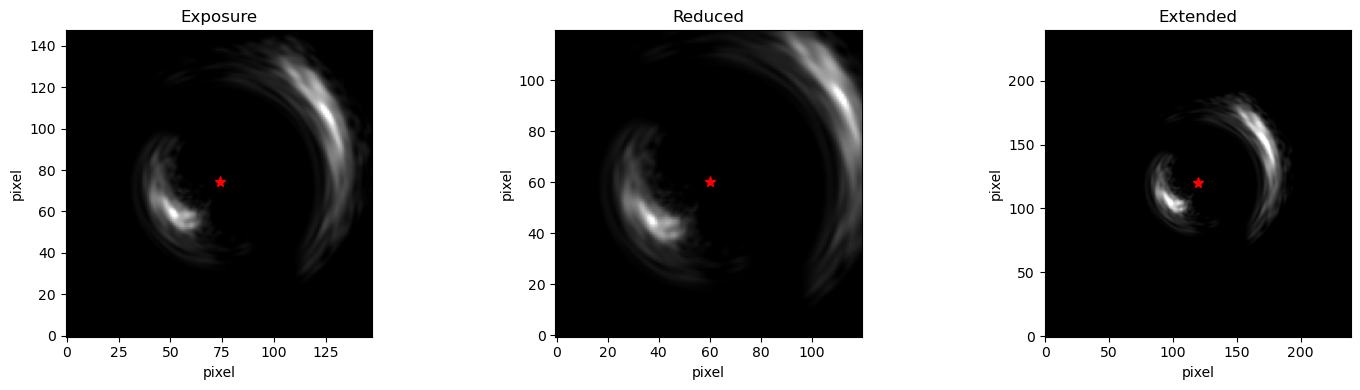

In [7]:
# ploting
exposure_ref = fits_to_exposure(data_stamp, hdr_stamp) # Converting to exposure
exposures = [exposure_ref,
             fits_to_exposure(cutoutfits, cutout_hdrfits), # Converting to exposure
             fits_to_exposure(extoutfits, extout_hdrfits) # Converting to exposure
            ]

center_coord = exposure_ref.getWcs().pixelToSky(center_coord[0], center_coord[1])
plot_exposures_with_point(exposures, center_coord,
                          ['Exposure', 'Reduced', 'Extended'],
                         ['pixel', 'pixel'])

### Roting the exposure and saving with the same size

In [8]:
angle_list = [0, 30, 180, 360] # [0, 30, 45, 90]  # [0, 0, 0, 0, 0, 0]

rotate_stamps_list = []
for rotation_angle in angle_list:
    data_temp, hdr_temp = vr.apply_correction_from_exposureF(
        data_stamp, hdr_stamp, rotation_angle,
        warping_kernel='lanczos4',
        keep_size=False,
        update_wcs=True
    )

    # Converting to exposure
    temp = fits_to_exposure(data_temp, hdr_temp)
    
    rotate_stamps_list.append(temp)

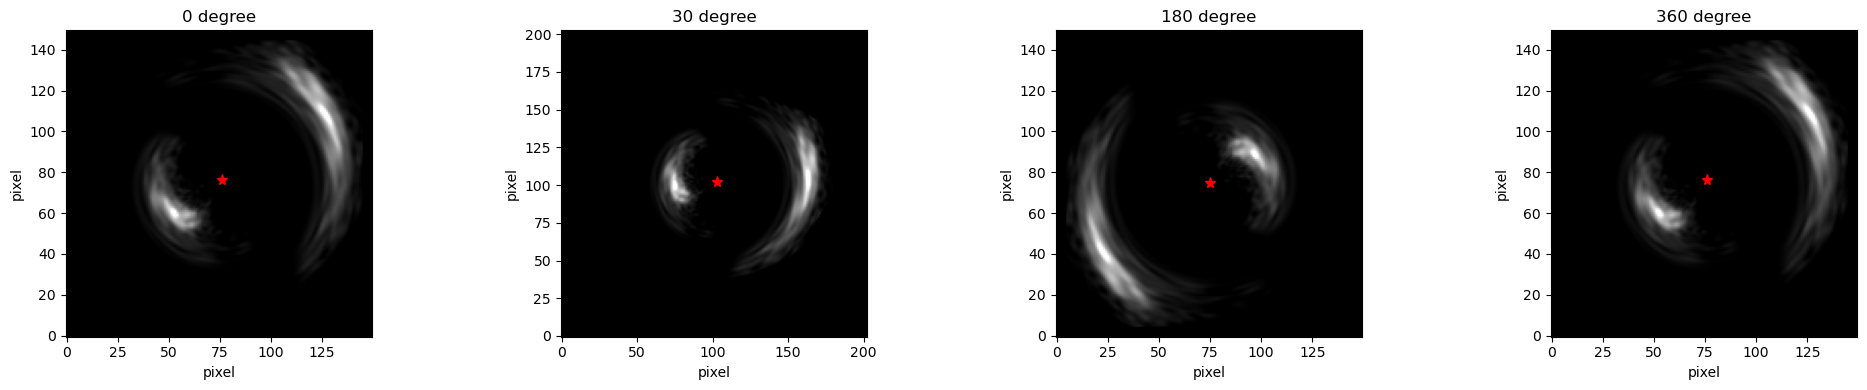

In [9]:
center_coord = exposure_ref.getWcs().pixelToSky(center_coord[0], center_coord[1])

# Making a referential point
inX, inY = exposure_ref.image.array.shape[0]/2, exposure_ref.image.array.shape[0]/2
center_coord = exposure_ref.getWcs().pixelToSky(inX, inY)

plot_exposures_with_point(rotate_stamps_list, center_coord,
                          [str(i) + ' degree' for i in angle_list],
                          ['pixel', 'pixel'])

Notice that in general, every stamp has a different size. Fixing its sizes:

In [10]:
radius = 120
cut_rotate_stamps_list = []
for rot_stamp in rotate_stamps_list:
    cutout_temp = cutout_exposure(rot_stamp, center_coord, radius, info=False)
    cut_rotate_stamps_list.append(cutout_temp)

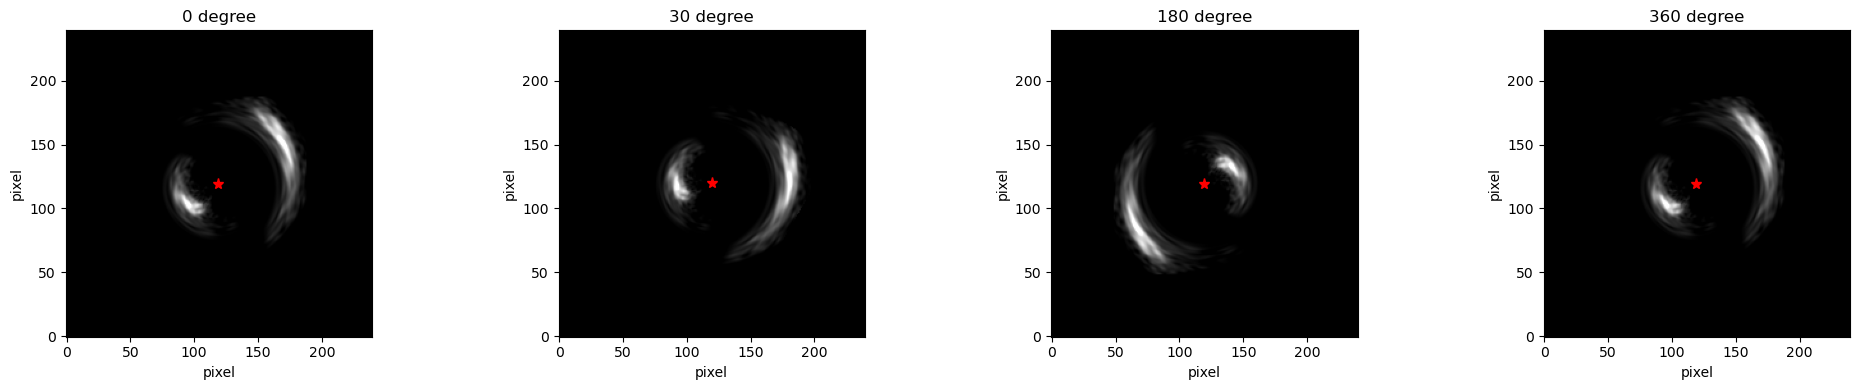

In [11]:
plot_exposures_with_point(cut_rotate_stamps_list, center_coord,
                          [str(i) + ' degree' for i in angle_list],
                          ['pixel', 'pixel'])

--> lanczos4 3.8025252e-07


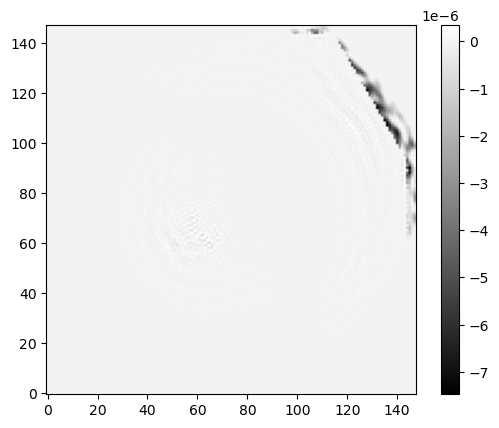

--> lanczos3 2.820126e-07


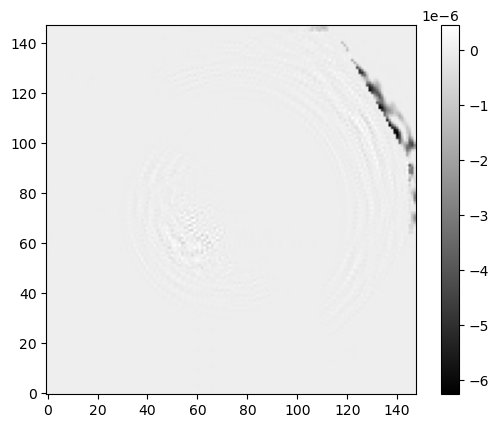

--> bilinear 3.963532e-07


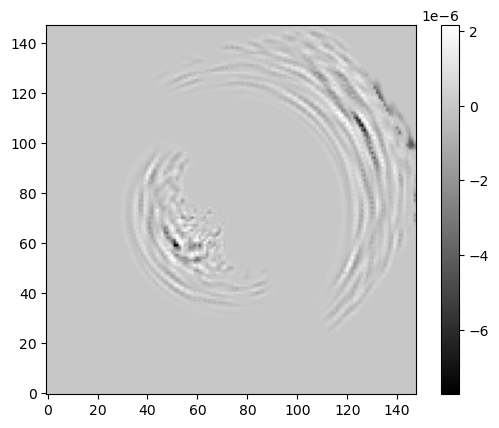

In [12]:
# checks rotation procedure

# Test rotation kernel
A = data_stamp.copy()

for k in ['lanczos4', 'lanczos3', 'bilinear']: #, 'bilinear', 'lanczos3'
    B, hdrB = vr.apply_correction_from_exposureF(A, hdr_stamp, 30, warping_kernel=k, keep_size=True, update_wcs=True)
    A2, _ = vr.apply_correction_from_exposureF(B, hdrB, -30, warping_kernel=k, keep_size=True, update_wcs=False)
    diff = A2 - A
    print('-->', k, np.sqrt(np.mean(diff**2)))
    plt.imshow(diff, origin='lower', cmap='gray', vmin=np.nanpercentile(diff, 0.01),
                  vmax=np.nanpercentile(diff, 99.9))

    #plt.xlim(0, 150)
    #plt.ylim(0, 150)
    plt.colorbar()
    plt.show()

--> bilinear 2.320606e-06
30


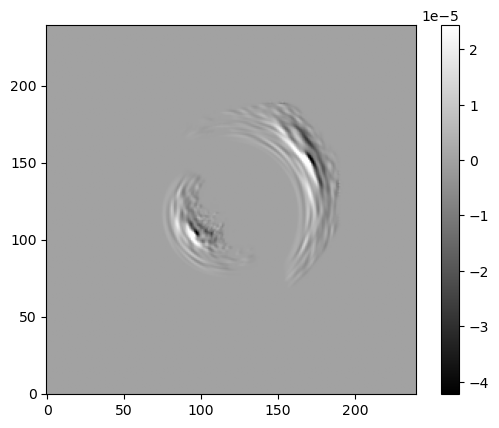

--> bilinear 5.1928364e-06
180


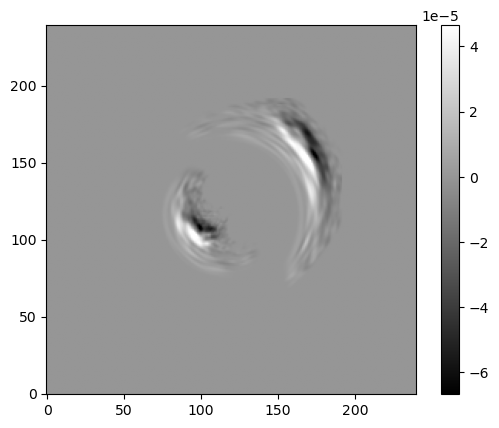

--> bilinear 1.2391789e-12
360


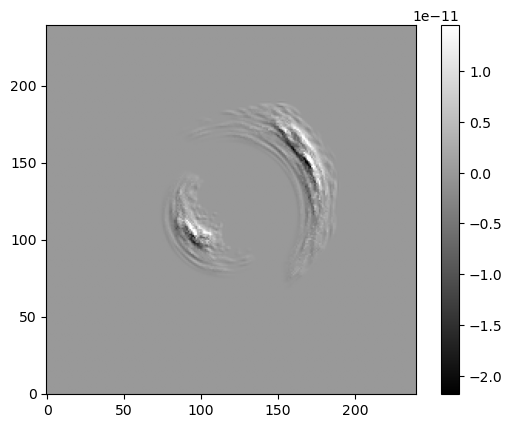

In [13]:
# Test rotation kernel
A, _ = exposure_to_fits_datahdr(cut_rotate_stamps_list[0])

for ind, r_stamp_exp in enumerate(cut_rotate_stamps_list[1:], start=1): #, 'bilinear'
    data, hdr = exposure_to_fits_datahdr(r_stamp_exp)
    angle = angle_list[ind]
    B, _ = vr.apply_correction_from_exposureF(data, hdr, -angle, warping_kernel='lanczos4',
                                              keep_size=True, update_wcs=False)
    diff = A - B
    print('-->', k, np.sqrt(np.mean(diff**2)))
    print(angle)
    plt.imshow(diff, origin='lower', cmap='gray', vmin=np.nanpercentile(diff, 0.01),
                  vmax=np.nanpercentile(diff, 99.9))

    #plt.xlim(0, 150)
    #plt.ylim(0, 150)
    plt.colorbar()
    plt.show()

In [14]:
# check the rotation
for i in range(1, len(angle_list)):
    averpix = validate_rotation(cut_rotate_stamps_list[0].getImage().getArray(),
                  cut_rotate_stamps_list[i].getImage().getArray(), rotation_angle=angle_list[i], n_points=20)
    print(averpix)

Average pixel intensity error after rotation: 0.000007
7.493645e-06
Average pixel intensity error after rotation: 0.000004
4.049919e-06
Average pixel intensity error after rotation: 0.000000
0.0


In [202]:
np.nanpercentile(diff, 99.9), np.max(diff)

(np.float32(1.4551915e-11), np.float32(2.910383e-11))

### Making a coadd 

[INFO] Starting coaddition of 4 exposures...
Warp 1: 0.000% NaN pixels
Offset (degree): 0.0
Rotation angle (degree): 0.0
→ Total diff: 0.0 Max: 0.0 Min: 0.0


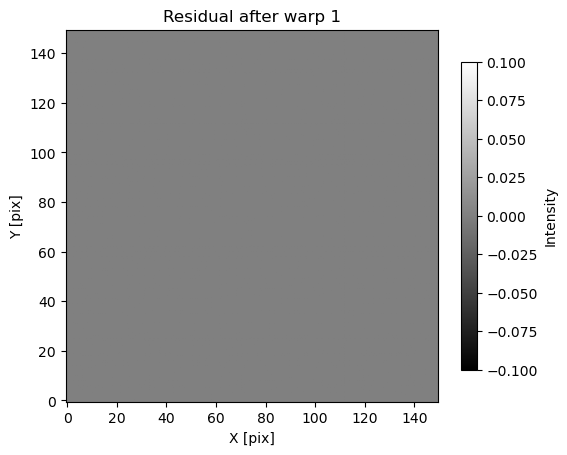

[1/4] exposure coadded.
Warp 2: 0.400% NaN pixels
Offset (degree): 15.450287981967469
Rotation angle (degree): 330.0
→ Total diff: 7.881739e-05 Max: 1.395127e-05 Min: 0.0


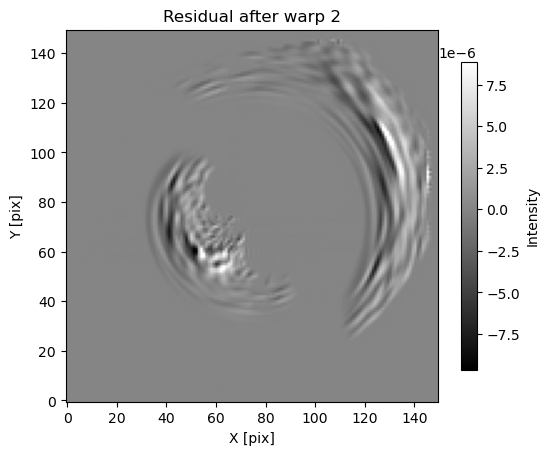

[2/4] exposure coadded.
Warp 3: 9.116% NaN pixels
Offset (degree): 0.30671674320546205
Rotation angle (degree): 180.0
→ Total diff: 0.0 Max: 6.0850616e-05 Min: 0.0


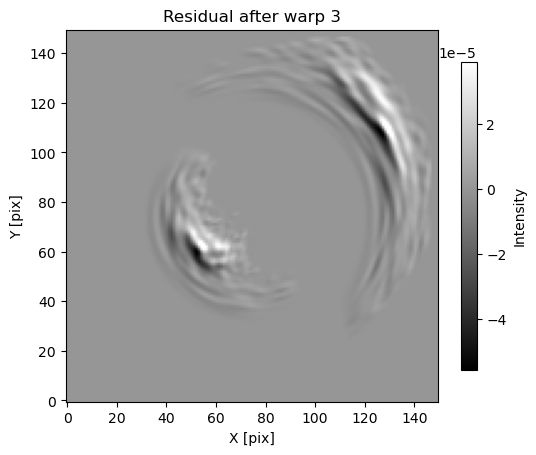

[3/4] exposure coadded.
Warp 4: 0.000% NaN pixels
Offset (degree): 0.0
Rotation angle (degree): 0.0
→ Total diff: 0.0 Max: 0.0 Min: 0.0


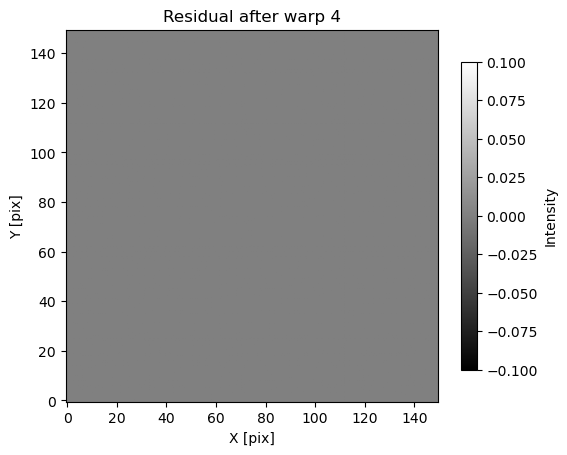

[4/4] exposure coadded.
[INFO] LSST-style coadd saved to ./coadds_stamp_rotation/stamp_rotation_0.fits
[INFO] Coverage map saved to ./coadds_stamp_rotation/coverage_map.fits
Coaddition complete.
Pixels with no coverage: 0 / 22500


In [17]:
coadd_exp_0, coverage_map_0 = vr.coadd_exposures_pipeline(
    rotate_stamps_list, 
    ref_exp=rotate_stamps_list[0],
    warping_kernel="lanczos4",  # "lanczos3"
    save_path="./coadds_stamp_rotation",
    coadd_name=f"stamp_rotation_0.fits",
    info=True,
    plot_debug=True,
    same_check=True
)

[INFO] Starting coaddition of 4 exposures...
→ Total diff: 0.0 Max: 0.0 Min: 0.0


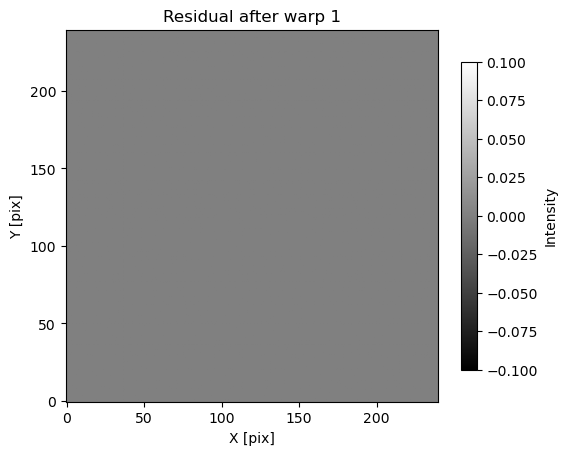

[1/4] exposure coadded.
→ Total diff: 7.881576e-05 Max: 1.395127e-05 Min: 0.0


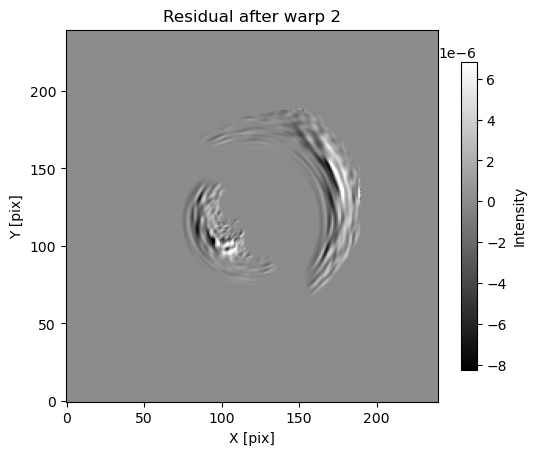

[2/4] exposure coadded.
→ Total diff: 0.0 Max: 6.0850616e-05 Min: 0.0


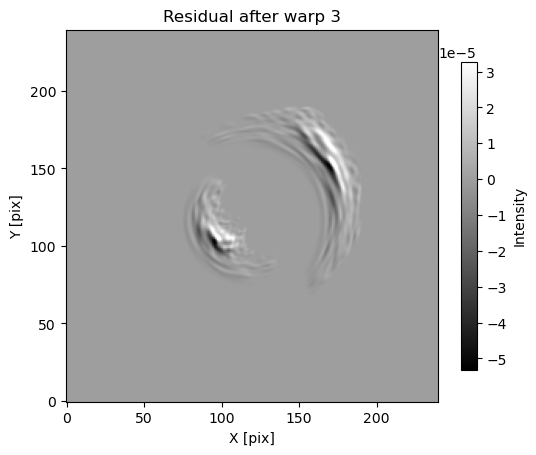

[3/4] exposure coadded.
→ Total diff: 0.0 Max: 0.0 Min: 0.0


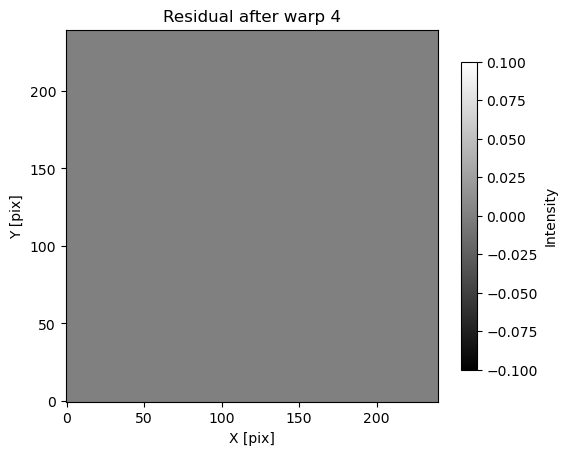

[4/4] exposure coadded.
[INFO] LSST-style coadd saved to ./coadds_stamp_rotation/stamp_rotation.fits
[INFO] Coverage map saved to ./coadds_stamp_rotation/coverage_map.fits
Coaddition complete.
Pixels with no coverage: 16310 / 57600


In [18]:
coadd_exp, coverage_map = vr.coadd_exposures_pipeline(
    cut_rotate_stamps_list, 
    ref_exp=None,
    warping_kernel="lanczos4",  # "lanczos4" "bilinear"
    save_path="./coadds_stamp_rotation",
    coadd_name=f"stamp_rotation.fits",
    plot_debug=True,
    same_check=True)

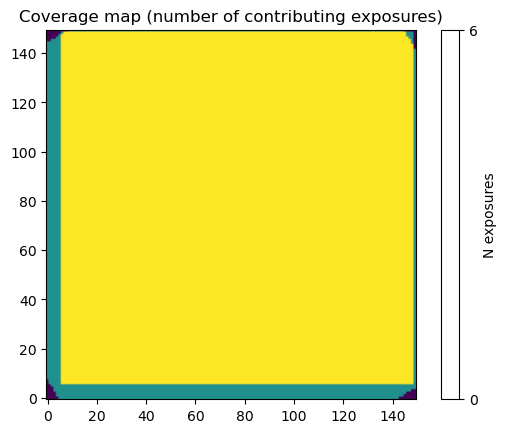

In [16]:
plt.imshow(coverage_map_0, origin='lower', cmap='viridis')
plt.contour(coverage_map_0, levels=[0, 6], colors='white', linewidths=0.8)
plt.title('Coverage map (number of contributing exposures)')
plt.colorbar(label='N exposures')
plt.show()

In [19]:
# Loading the Exposure Coadd
from lsst.afw.image import ExposureF

coadd_exp_0 = ExposureF.readFits(f"./coadds_stamp_rotation/stamp_rotation_0.fits")
coadd_exp = ExposureF.readFits(f"./coadds_stamp_rotation/stamp_rotation.fits")

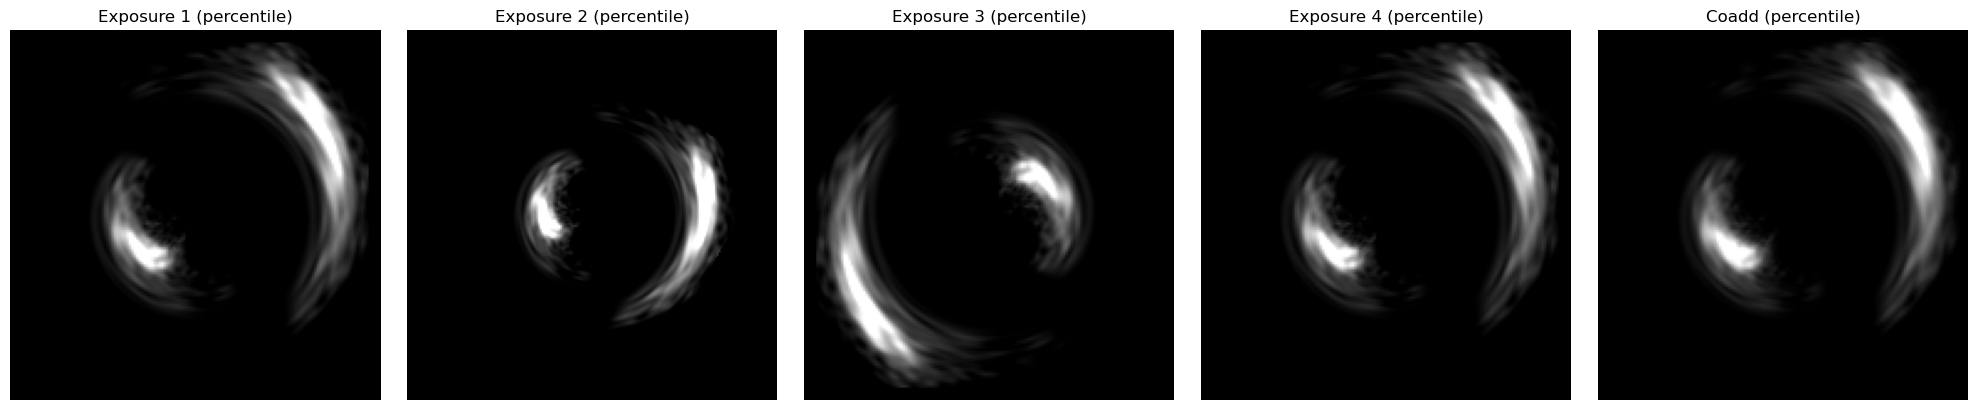

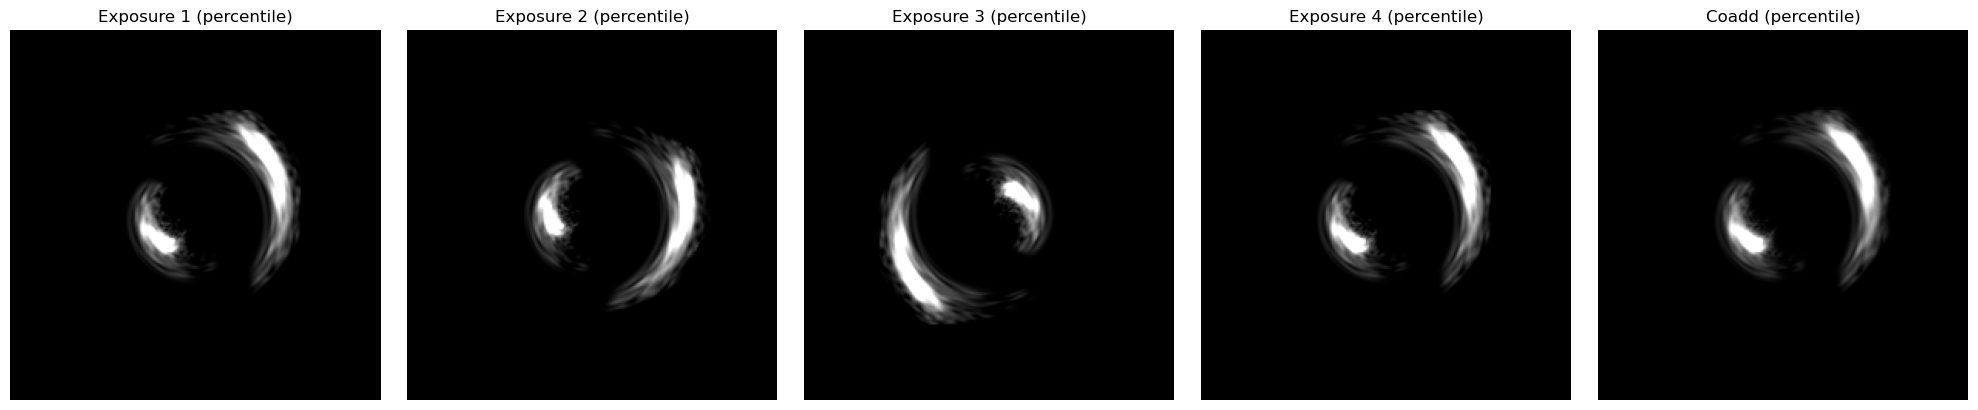

In [20]:
# Visualizing the result 
vr.plot_exposures_and_coadd(rotate_stamps_list,
                         coadd_exp_0,
                         exposures_scale='percentile', # 'zscale_asinh',
                         coadd_exp_scale='percentile', # 'percentile' zscale_asinh
                         show_second_row=False,
                         save_path=None)

vr.plot_exposures_and_coadd(cut_rotate_stamps_list,
                         coadd_exp,
                         exposures_scale='percentile', # 'zscale_asinh',
                         coadd_exp_scale='percentile', # 'percentile' zscale_asinh
                         show_second_row=False,
                         save_path=None)

[INFO] Converted LSST SkyWcs -> Astropy WCS


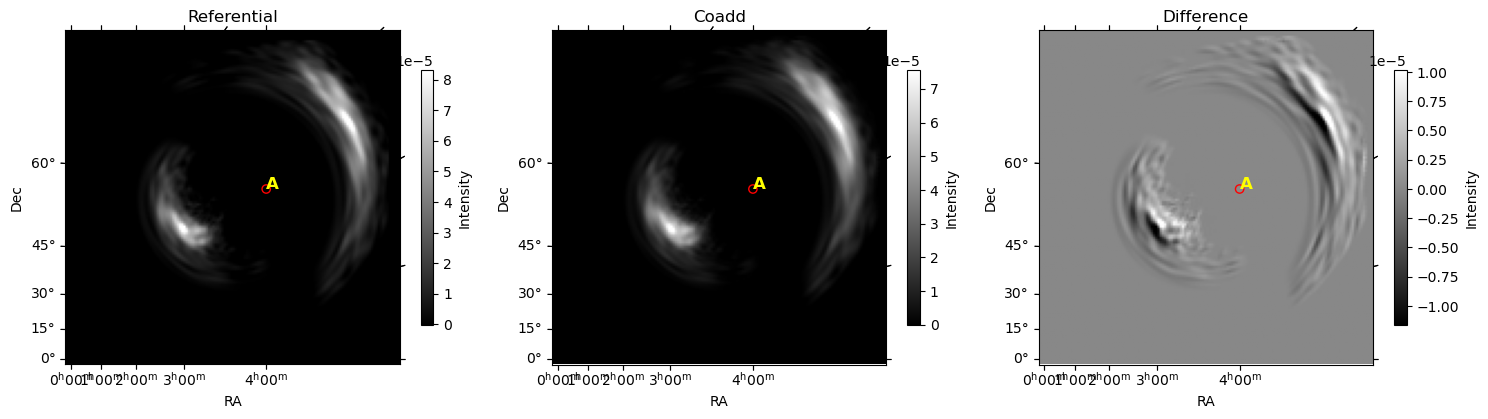

In [21]:
points = [[60, 37]] # no importa
vr.injection_steps(
    rotate_stamps_list[0],
    coadd_exp_0,
    points,
    diference=True,
    cutout_radius_arcsec=None,  # arcsec 
    grid=False, percentiles=[.1, 99.9],
    names=['Referential', 'Coadd', 'Difference'])

[INFO] Converted LSST SkyWcs -> Astropy WCS


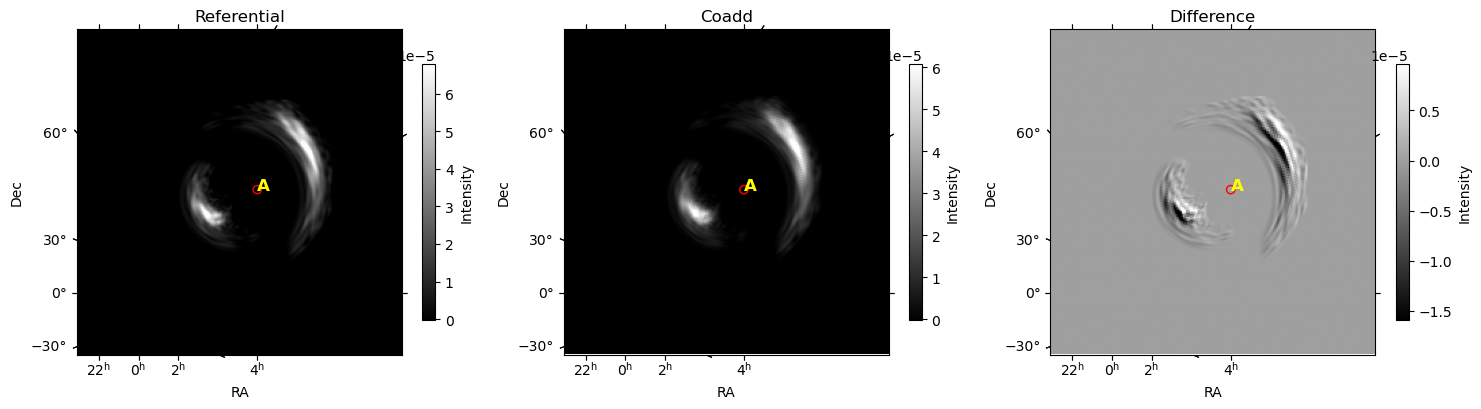

In [176]:
points = [[60, 37]] # no importa
vr.injection_steps(
    cut_rotate_stamps_list[0],
    coadd_exp,
    points,
    diference=True,
    cutout_radius_arcsec=None,  # arcsec 
    grid=False, percentiles=[0.1, 99.9], #[5, 95]
    names=['Referential', 'Coadd', 'Difference'])

In [ ]:
# fast test
warped_exp, residual, residual_norm = leave_one_out_residual(rotate_stamps_list[1],
                                    rotate_stamps_list[0], warping_kernel="lanczos3")

temp = [warped_exp, residual, residual_norm]
plot_exposures_with_point(temp, center_coord=None, titles=['coadd', 'residual', 'residual_norm'],
                          axeslabels=['pixel', 'pixel'],
                          percentiles=[0.1, 99.9])